In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-huge").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# huggingface 공식 이미지
# img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import numpy as np
# 로컬 파일 경로
img_path = "/content/drive/MyDrive/Colab Notebooks/deepdaiv/data/test_mask2.png"

# requests.get 대신 Image.open을 사용하여 이미지 로드
raw_image = Image.open(img_path).convert("RGB")
raw_image = raw_image.resize((384, 384))

# input_points 정의
input_points = [[[128, 224], [192, 320],[256, 224]]]  # 2D localization of a window
# input_boxes = [[[50,128],[450, 450]]]
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to("cuda")
# inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to("cuda")
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores


torch.Size([3, 384, 384])
torch.Size([384, 384])


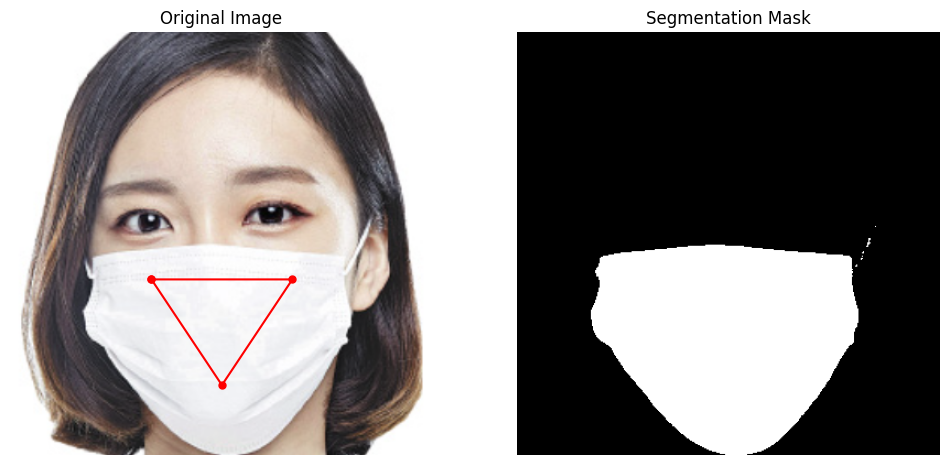

In [4]:
# 예제 코드 수정: 단일 채널 마스크 시각화
import matplotlib.pyplot as plt

# 원본 이미지와 마스크 이미지를 나란히 표시
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 표시
axs[0].imshow(raw_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# 마스크 표시를 위해 첫 번째 채널 선택 (단일 채널 마스크를 가정)
# 여기서는 마스크가 Bool 타입이어도 문제 없으며, 직접 imshow에 전달할 수 있습니다.

mask = masks[0].squeeze()  # Squeeze는 여전히 필요할 수 있으나, 실제 데이터 형태에 따라 다름
print(mask.shape)
if mask.ndim > 2:
    mask = mask[0]  # 첫 번째 채널 선택
print(mask.shape)

# 입력 포인트를 이미지 위에 표시
for points in input_points:
    # 각 점을 차례로 연결하여 다각형을 그립니다.
    poly = np.array(points)  # 점들의 배열을 numpy 배열로 변환
    poly = np.append(poly, [poly[0]], axis=0)  # 첫 번째 점을 다시 추가하여 다각형을 닫습니다.
    axs[0].plot(poly[:, 0], poly[:, 1], marker='o', markersize=5, linestyle='-', color='red')  # 다각형 그리기

# 마스크 시각화
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Segmentation Mask')
axs[1].axis('off')

plt.show()


Mask shape: torch.Size([384, 384])
Image shape: (384, 384, 3)


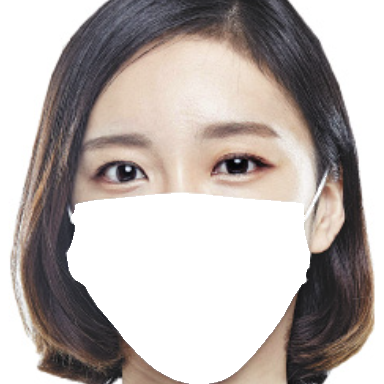

In [5]:
# 원본 이미지를 NumPy 배열로 변환
image_np = np.array(raw_image)
print("Mask shape:", mask.shape)
print("Image shape:", image_np.shape)
# # 마스크에 해당하는 픽셀을 하얀색으로 변경
# # 하얀색은 RGB에서 (255, 255, 255)입니다.
image_np[mask] = [255, 255, 255]

# # 변경된 이미지 데이터를 다시 PIL Image로 변환
processed_image = Image.fromarray(image_np)

# # 결과 이미지 표시
from IPython.display import display

# 변경된 이미지 인라인으로 표시
display(processed_image)

In [6]:
import torch
import gc

# 더 이상 필요하지 않은 변수 삭제
del inputs, outputs, masks, scores
torch.cuda.synchronize() # GPU 작업이 모두 완료될 때까지 기다립니다.

# Python 가비지 컬렉터 호출
gc.collect()

# CUDA 캐시 메모리 비우기
torch.cuda.empty_cache()

# 이후의 코드...
